
![airline_delays](https://miro.medium.com/max/1180/1*7pKBn-RXnqvrl-joQgMwZw.jpeg)

# Airline Delays
**Dataset Case Study**
The data used will be taken from Kaggle's datasets **Airlines Delay** found at [Kaggle](https://www.kaggle.com/giovamata/airlinedelaycauses) by [Giovanni Gonzalez](https://www.kaggle.com/giovamata)

# 1. Data preparation
In order to analyze the data, the dataset first has to be processed, cleaned and polished.

## 1.1. Imports
Python libraries

In [36]:
import pandas as pd
import os
!pip install kaggle --upgrade --quiet
import seaborn as sns
sns.set_theme(style="darkgrid")
sns.set(rc = {'figure.figsize':(15,8)})

os.getcwd()

'/home/noone/data-exercises/kaggle-airline-df'

## 1.2. Project folder structure
Let's do a simple folder structure in order to organize all the working data.

| root
|--- kaggle-airline-df
|---|--- input

In [2]:
# Prepare directories
root = os.getcwd()

# Change working directory
if "kaggle-airline-df" in root:
    wd_dir = root
else:
    wd_dir = os.path.join(root,"kaggle-airline-df")
    os.mkdir(wd_dir)
    os.chdir(wd_dir)

## 1.3. Download the dataset
Using Kaggle's API, download the entire dataset

In [12]:
# Download the dataset using Kaggle's API
dataset_dir = os.path.join(wd_dir,"input")

if not os.path.isdir(dataset_dir):
    os.mkdir(dataset_dir)
    os.chdir(dataset_dir)
    !kaggle datasets download giovamata/airlinedelaycauses
    !unzip airlinedelaycauses.zip
    !rm airlinedelaycauses.zip

# Return to the main directory
os.chdir(wd_dir)

# 2. Dataset
Load the dataset to perform exploration, cleaning, rearranging and imputation.

## 2.1. Loading the dataset
Previewing the dataset and then loading it full

In [3]:
# Load only the column names from the CSV file
file_name = "input/DelayedFlights.csv"
col_names = pd.read_csv(file_name, nrows=1).columns.tolist()
print(col_names)

['Unnamed: 0', 'Year', 'Month', 'DayofMonth', 'DayOfWeek', 'DepTime', 'CRSDepTime', 'ArrTime', 'CRSArrTime', 'UniqueCarrier', 'FlightNum', 'TailNum', 'ActualElapsedTime', 'CRSElapsedTime', 'AirTime', 'ArrDelay', 'DepDelay', 'Origin', 'Dest', 'Distance', 'TaxiIn', 'TaxiOut', 'Cancelled', 'CancellationCode', 'Diverted', 'CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay']


In [4]:
# Let's list the undesired columns
undesired_cols_indices = ["CancellationCode"]
# Remove them from the col_names
dummy = [col_names.remove(undesired) for undesired in undesired_cols_indices]

In [21]:
# Now load the CSV data file with only the desired data, using the first column as index.
# The index usually does not have any name, maybe because of that the shown name is "Unnamed:0"
df = pd.read_csv(file_name, usecols=col_names, index_col=0)
# Let's take a look
df.head()

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,...,Distance,TaxiIn,TaxiOut,Cancelled,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
0,2008,1,3,4,2003.0,1955,2211.0,2225,WN,335,...,810,4.0,8.0,0,0,NaN,NaN,NaN,NaN,NaN
1,2008,1,3,4,754.0,735,1002.0,1000,WN,3231,...,810,5.0,10.0,0,0,NaN,NaN,NaN,NaN,NaN
2,2008,1,3,4,628.0,620,804.0,750,WN,448,...,515,3.0,17.0,0,0,NaN,NaN,NaN,NaN,NaN
4,2008,1,3,4,1829.0,1755,1959.0,1925,WN,3920,...,515,3.0,10.0,0,0,2.0,0.0,0.0,0.0,32.0
5,2008,1,3,4,1940.0,1915,2121.0,2110,WN,378,...,688,4.0,10.0,0,0,NaN,NaN,NaN,NaN,NaN


## 2.2. Cleaning
Fix data types and dates

In [22]:
# Let's check the actual datatypes associated to each variable
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1936758 entries, 0 to 7009727
Data columns (total 28 columns):
 #   Column             Dtype  
---  ------             -----  
 0   Year               int64  
 1   Month              int64  
 2   DayofMonth         int64  
 3   DayOfWeek          int64  
 4   DepTime            float64
 5   CRSDepTime         int64  
 6   ArrTime            float64
 7   CRSArrTime         int64  
 8   UniqueCarrier      object 
 9   FlightNum          int64  
 10  TailNum            object 
 11  ActualElapsedTime  float64
 12  CRSElapsedTime     float64
 13  AirTime            float64
 14  ArrDelay           float64
 15  DepDelay           float64
 16  Origin             object 
 17  Dest               object 
 18  Distance           int64  
 19  TaxiIn             float64
 20  TaxiOut            float64
 21  Cancelled          int64  
 22  Diverted           int64  
 23  CarrierDelay       float64
 24  WeatherDelay       float64
 25  NASDelay          

In [23]:
# Are there NaNs?
nans = df.isna().sum().sum()
print(f'There are {nans} NaNs')

There are 3486389 NaNs


In [29]:
# The NaNs detected are observations of value zero, so let's substitute them with proper 0s
df.fillna(value=0,inplace=True) #TODO explain why

# Now, all the variables in the dataset that are not strings should be represented without decimals.
# So they can be converted into integer
# Select all columns which are not strings and loop to convert to type "int"
col_int = df.select_dtypes(exclude=[object]).columns.tolist()

for col_name in col_int:
    df[col_name] = df[col_name].astype("int")

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1936758 entries, 0 to 7009727
Data columns (total 28 columns):
 #   Column             Dtype 
---  ------             ----- 
 0   Year               int64 
 1   Month              int64 
 2   DayofMonth         int64 
 3   DayOfWeek          int64 
 4   DepTime            int64 
 5   CRSDepTime         int64 
 6   ArrTime            int64 
 7   CRSArrTime         int64 
 8   UniqueCarrier      object
 9   FlightNum          int64 
 10  TailNum            object
 11  ActualElapsedTime  int64 
 12  CRSElapsedTime     int64 
 13  AirTime            int64 
 14  ArrDelay           int64 
 15  DepDelay           int64 
 16  Origin             object
 17  Dest               object
 18  Distance           int64 
 19  TaxiIn             int64 
 20  TaxiOut            int64 
 21  Cancelled          int64 
 22  Diverted           int64 
 23  CarrierDelay       int64 
 24  WeatherDelay       int64 
 25  NASDelay           int64 
 26  SecurityDelay 

In [30]:
# The first columns are daily data separated by some non standard rule. Let's convert them into date datatype.
convert_dict = {
    "Year": str,
    "Month": str,
    "DayofMonth": str
}
df = df.astype(convert_dict) # Convert to string

df["Date"] = df["Year"] + "/" + df["Month"] + "/" + df["DayofMonth"]
df["Date"] = pd.to_datetime(df["Date"],format="%Y/%m/%d")

# Now drop the columns
df.drop(columns=["Year","Month","DayofMonth"],inplace=True)

In [49]:
# Are there NaNs?
nans = df.isna().sum().sum()
print(f'There are {nans} NaNs')
df.head()

There are 0 NaNs


,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,CRSElapsedTime,...,TaxiIn,TaxiOut,Cancelled,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,avg-delay
Date,,,,,,,,,,,,,,,,,,,,,
2008-01-03,4,2003,1955,2211,2225,WN,335,N712SW,128,150,...,4,8,0,0,0,0,0,0,0,34.626992
2008-01-03,4,754,735,1002,1000,WN,3231,N772SW,128,145,...,5,10,0,0,0,0,0,0,0,34.626992
2008-01-03,4,628,620,804,750,WN,448,N428WN,96,90,...,3,17,0,0,0,0,0,0,0,34.626992
2008-01-03,4,1829,1755,1959,1925,WN,3920,N464WN,90,90,...,3,10,0,0,2,0,0,0,32,34.626992
2008-01-03,4,1940,1915,2121,2110,WN,378,N726SW,101,115,...,4,10,0,0,0,0,0,0,0,34.626992


# 3. Plot the data
You have to plot this parts:

3.1. Create a view for a categorical variable (UniqueCarrier)
3.2. Create a view for a numeric variable (ArrDelay)
3.3. Create a view for Variable numeric and category (ArrDelay and UniqueCarrier)
3.4. Create a view for Three variables (ArrDelay, DepDelay and UniqueCarrier)
3.5. Create a view for Two numeric variables (ArrDelay and DepDelay)
3.6. Create a view for Three variables (ArrDelay, DepDelay and UniqueCarrier)
3.7. Create a view for Three variables (ArrDelay, DepDelay and UniqueCarrier)
3.8. Create a view for More than three variables (ArrDelay, DepDelay, AirTime and UniqueCarrier

## 3.1. Categorical variable (UniqueCarrier)
As this is a categorical variable, a useful plot could be a histogram of the number of flights done by each carrier.

<AxesSubplot:xlabel='UniqueCarrier', ylabel='Count'>

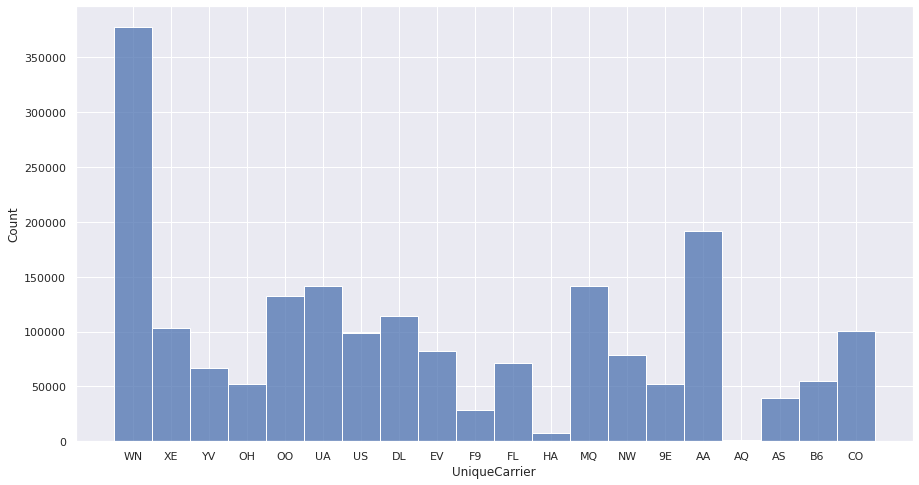

In [37]:
sns.histplot(data=df, x="UniqueCarrier")

## 3.2. Numerical variable (ArrDelay)
This numerical value is related to time, so a nice plot could be a line plot with date timestamps

<AxesSubplot:xlabel='Date', ylabel='ArrDelay'>

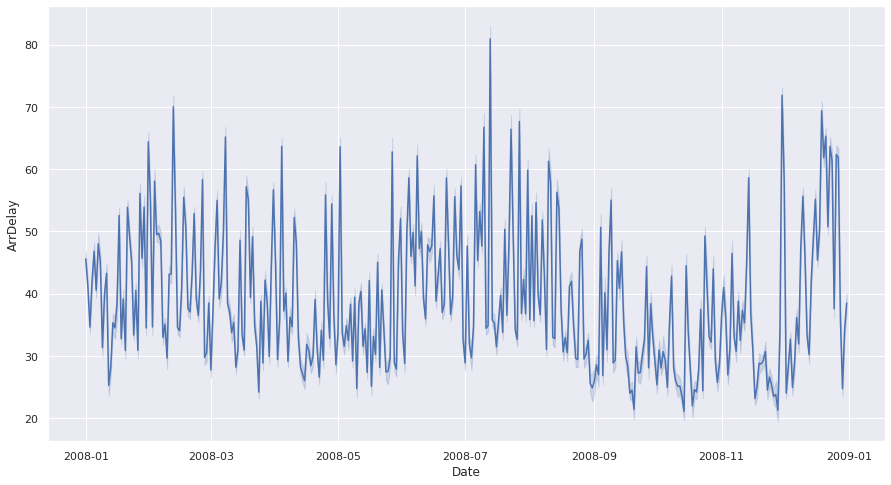

In [38]:
sns.lineplot(data=df, x="Date",y="ArrDelay")

From the previous plot we can see that there is no clarity on the data, so a new approach should be made.
i.e.: use the average for the main line with hues for the deviation.

In [50]:
df.set_index("Date", inplace=True)

KeyError: "None of ['Date'] are in the columns"

In [47]:
df["avg-delay"] = df["ArrDelay"].groupby(pd.Grouper(freq="D")).mean()

In [52]:
df

,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,CRSElapsedTime,...,TaxiIn,TaxiOut,Cancelled,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,avg-delay
Date,,,,,,,,,,,,,,,,,,,,,
2008-01-03,4,2003,1955,2211,2225,WN,335,N712SW,128,150,...,4,8,0,0,0,0,0,0,0,34.626992
2008-01-03,4,754,735,1002,1000,WN,3231,N772SW,128,145,...,5,10,0,0,0,0,0,0,0,34.626992
2008-01-03,4,628,620,804,750,WN,448,N428WN,96,90,...,3,17,0,0,0,0,0,0,0,34.626992
2008-01-03,4,1829,1755,1959,1925,WN,3920,N464WN,90,90,...,3,10,0,0,2,0,0,0,32,34.626992
2008-01-03,4,1940,1915,2121,2110,WN,378,N726SW,101,115,...,4,10,0,0,0,0,0,0,0,34.626992
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2008-12-13,6,1250,1220,1617,1552,DL,1621,N938DL,147,152,...,9,18,0,0,3,0,0,0,22,30.229644
2008-12-13,6,657,600,904,749,DL,1631,N3743H,127,109,...,15,34,0,0,0,57,18,0,0,30.229644
2008-12-13,6,1007,847,1149,1010,DL,1631,N909DA,162,143,...,8,32,0,0,1,0,19,0,79,30.229644


In [ ]:
sns.lineplot(data=df, x="Date",y="avg-delay")